# Multilabel

In [1]:
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [2]:
sys.path.append('..')
from kernel import KernelComputer, KernelRegressor
from dataloader import MULANLoader, FoldsGenerator, Synthesizer
from multilabel import DF, IL

In [3]:
np.random.seed(0)

In [4]:
n_train = 100
n_test = 1000
datagen = Synthesizer('ML-' + str(n_train))

In [5]:
corruption = .3

x_train, y_train = datagen.get_trainset()
x_test, y_test = datagen.get_testset(n_test)
S_train = datagen.synthetic_corruption(y_train, corruption)

[ 9. 10. 12. 17. 18. 20. 33. 34. 36.]


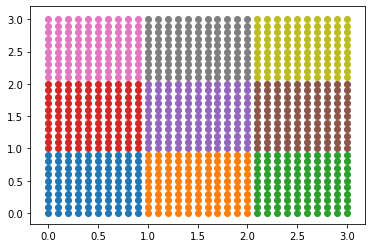

In [7]:
def plot_pb(x_test, y_test):
    fig, ax = plt.subplots(figsize=(6, 4))
    index = ((y_test + 1) * [1, 2, 4, 8, 16, 32] / 2).sum(axis=1)
#     index = ((y_test + 1) * [1, 2, 4, 8] / 2).sum(axis=1)
    print(np.unique(index))
    color = {9: 'C0', 10:'C1', 12:'C2', 17:'C3', 18:'C4', 20:'C5', 33:'C6', 34:'C7', 36:'C8',}
#              3: 'C9', 6: 'bisque', 9:'salmon', 12:'chocolate', 24:'thistle'}
#     color = {0: 'C0', 1:'C1', 2:'C2', 4:'C3', 5:'C4', 6:'C5', 8:'C6', 9:'C7', 10:'C8',}
    for i in np.unique(index):
        ind = index == i
        if i in color:
            c = color[i]
        else:
            c = 'k'
        ax.scatter(x_test[ind, 0], x_test[ind ,1], color=c)
    return fig

plot_pb(x_test, y_test);

In [24]:
kernel_type = 'Gaussian'
k = 2
sigma = .3
lambd = 1e-2

kernel = KernelComputer(kernel_type, sigma=sigma)
kernel_reg = KernelRegressor(kernel)
met_df, met_il = DF(kernel, k), IL(kernel, k)

met_df.train(x_train, S_train, lambd)
met_il.train(x_train, S_train, lambd)

y_df = met_df(x_test)
y_il = met_il(x_test)

In [25]:
(y_df != y_test).mean(), (y_il != y_test).mean()

(0.04266389177939646, 0.053069719042663895)

[ 9. 10. 12. 17. 18. 20. 33. 34. 36.]
[ 9. 10. 12. 17. 18. 20. 33. 34. 36.]
[ 9. 10. 12. 17. 18. 20. 33. 34. 36. 48.]


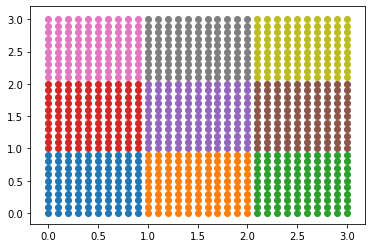

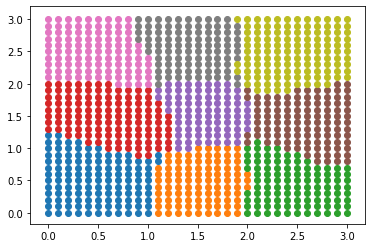

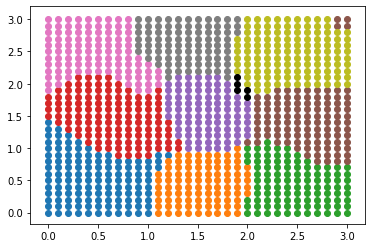

In [26]:
plot_pb(x_test, y_test);
plot_pb(x_test, y_df);
plot_pb(x_test, y_il);

#### Cross validation scripts

In [16]:
def get_err(name, corruptions, nb_folds, sigmas, lambdas, kernel_type, skewed):
    loader = MULANLoader(name)
    x, y = loader.get_trainset()
    
    ind = y.sum(axis=0) != 0
    y = y[:, ind]
    k = int(np.sum(y == 1, axis=1).mean()) + 1

    kernel = KernelComputer(kernel_type, sigma=1)
    kernel_reg = KernelRegressor(kernel)
    met_df, met_il = DF(kernel, k), IL(kernel, k)
    shape_err = (len(corruptions), nb_folds, len(sigmas), len(lambdas))
    err_df, err_il = np.empty(shape_err), np.empty(shape_err)
    
    S = np.empty((*y.shape, len(corruptions)))
    for i_c, corruption in enumerate(corruptions):
        S[..., i_c] = loader.synthetic_corruption(y, corruption, skewed=skewed)
        
    floader = FoldsGenerator(x, y, S, nb_folds=nb_folds)
    for fold in range(nb_folds):
        (x_train, S_trains), (x_test, y_test) = floader()
        kernel_reg.set_support(x_train)
        n_train, dim = x_train.shape
        
        for i_s, c_sigma in enumerate(sigmas):
            sigma = c_sigma * dim
            kernel_reg.update_sigma(sigma)

            for i_l, c_lambda in enumerate(lambdas):
                lambd = c_lambda / np.sqrt(n_train)
                kernel_reg.update_lambda(lambd)
                alpha_train = kernel_reg(x_train)
                alpha = kernel_reg(x_test)

                for i_c, corruption in enumerate(corruptions):

                    S_train = S_trains[..., i_c]
                    y_dis = met_df.disambiguation(alpha_train, S_train, k)
                    pred_df = alpha @ y_dis
                    pred_il = alpha @ S_train

                    for pred in [pred_df, pred_il]:
                        idx = np.argsort(pred, axis=1)[:, -k:]
                        pred[:] = -1
                        met_il.fill_topk_pred(pred, idx)

                    err_df[i_c, fold, i_s, i_l] = ((pred_df - y_test) != 0).mean()
                    err_il[i_c, fold, i_s, i_l] = ((pred_il - y_test) != 0).mean()
            print(end='.')
    return err_df, err_il


def get_best_res(name, err_df, err_il, lambdas, sigmas):
    mus = np.empty((2, len(corruptions)))
    stds = np.empty((2, len(corruptions)))
    best_lambdas = np.empty((2, len(corruptions)))
    best_sigmas = np.empty((2, len(corruptions)))
    
    for j, err in zip([0, 1], [err_df, err_il]):
        tmp = err.reshape(err.shape[0], err.shape[1], -1)
        mu = tmp.mean(axis=1)
        ind = mu.argmin(axis=-1)
        for k in range(len(ind)):
            mus[j, k] = mu[k, ind[k]]
            stds[j, k] = tmp[k, :, ind[k]].std()            
            best_lambdas[j, k] = lambdas[ind[k] % len(lambdas)]
            best_sigmas[j, k] = sigmas[ind[k] // len(lambdas)]
    return mus, stds, best_lambdas, best_sigmas
